# Sedaro Rendezous Tutorial Notebook 
Demonstrates using the Sedaro API  to calculate Hohmann Rendezous manevuers between two satelite using a Jupyter notebook.

1. Manuever 1: Start a Hohmann transfer to raise the orbit of the chaser satelite to the same altitude as the target satelite.
2. Manuever 2: Complete the Hohmann transfer to match the velocity of the target satelite.
3. Manuever 3: Engage the Richard WARAT (Wicked Awesome Rendezous Approach Thrust) algorithm 

In [1]:
import sedaro
import math
import numpy as np
import json
import matplotlib.pyplot as plt
import hohmann_utils as hohmann

## Important: Read Before Running

This notebook makes changes to agent and scenario branches indicated in the settings section. Ensure any changes to the target branches are saved prior to running this code. Sedaro recommends committing current changes and creating new branches in the target repositories to avoid loss of work.

This notebook also requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.

## Sedaro python client setup
Note: More information about the sedaro-python client can be found here: [https://github.com/sedaro/sedaro-python]


In the next cell, adjust the following variables as needed
- *Sedaro_api_host*
- *Sedaro_api_token*

In [2]:
Sedaro_api_host  = "https://api.sedaro.com" 

# Set your API token value either directly or via loading a secrets file
# !! NOTE !!  Be careful not to check in your API Key into a source control repo  !! Note !!
secretPath = '/Users/sedaro/Documents/sedaro/sedaro-satellite/secrets.json'
with open(secretPath, 'r') as file:
    Sedaro_api_token = json.load(file)['API_KEY']
    
sedaroAPI = sedaro.SedaroApiClient(api_key=Sedaro_api_token, host=Sedaro_api_host)

Resources:
- Fundamentals of Astrodynamics 1971 (Bate, Mueller, White) pg 163, 362
- Fundamentals of Astrodynamics and Applications Fifth Edition 2022 (Vallado) pg 329, 367
 

*Orbits based on the Vanguard 1 TLE but made circular*

In [3]:

# orbits 
# TLE - 20Mar2024 from https://celestrak.org/NORAD/elements/gp.php?CATNR=5
# VANGUARD 1              
# 1 00005U 58002B   24078.99142898  .00000601  00000+0  79998-3 0  9992
# 2 00005  34.2449 325.2683 1840098  41.3159 331.2952 10.85238290354123

# circuliar_eccentricity = 0.0
# inclination_deg = 34.2449 # vanguard
# raan_deg = 325.2683 # vanguard
# argument_of_latitude_deg = 331 # vanguard

# helper constants
km_per_ER = 6378.1363
earth_u_ER = 1
sec_per_TU = 806.811

# helper functions
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))   


Create or use an existing workspace and record its ID. Uncomment and run whichever applies

In [4]:
workspace_id = "PLtYYcbJgKLbL8bcWbPG62"

Use a pre-defined Scenario with two space agents in co-planer circular orbits, a target agent and a chaser.  

In [5]:
scenario_branch_id = "PM6ncqJwpffbJhWSHk4mcM" 
chaser_agent_branch_id = "PM6ndHBL9dK6Nf9P3jk2Th" 
target_agent_branch_id = "PM6ndSgVhzg5JvvhvxYJCH"

scenario_branch     = sedaroAPI.scenario(scenario_branch_id)
chaser_agent_branch = sedaroAPI.agent_template(chaser_agent_branch_id)
target_agent_branch = sedaroAPI.agent_template(target_agent_branch_id)


# Load the agents 
First lets load the two space agents in order to calculate thier orbit radius and the phase angle between them

In [6]:
chaser_agent_name = "Chaser"
target_agent_name = "Target"

chaser_agent = scenario_branch.Agent.get_where(name=chaser_agent_name)[0]
target_agent = scenario_branch.Agent.get_where(name=target_agent_name)[0]


In [7]:
chaser_agent


TemplatedAgent(
   angularVelocity=None
   attitude=None
   disabled=False
   externalState=[]
   id='PLxJwpyLdr7FdzzD6SHHB4'
   kinematics='PLxJwpFVbjh46rPCmKZP7w'
   name='Chaser'
   position={'eci': [3433.215777939846, -5793.6160968387, -1909.7230020493562]}
   targetGroupMapping={}
   targetMapping={}
   templateRef='PM6ncpTftbpmBpyrsHw4cp'
   type='TemplatedAgent'
   velocity=[6.114913472565775, 2.3993880694729044, 3.713985779758385]
)

Note the eci initial position is already calculated  

In [8]:
# get the intial positons of the agents
chaser_initial_position = chaser_agent.position
target_initial_position = target_agent.position

# calculate the agents orbit radius
chaser_radius_km =  np.linalg.norm( chaser_initial_position['eci'] )
target_radius_km =  np.linalg.norm( target_initial_position['eci'] )

phase_angle_deg =  angle_between(chaser_initial_position['eci'], target_initial_position['eci']) * 180 / math.pi


Calc the two hohmann manuever times and delta V

In [9]:
# convert the radii to canonical units
a_chaser_ER = hohmann.calc_radaii_canonical_units(chaser_radius_km)
a_target_ER = hohmann.calc_radaii_canonical_units(target_radius_km) 
a_chaser_ER, a_target_ER

(1.0974992804716326, 1.567856114959475)

Calculate the wait time till the first transfer orbit burn 

In [10]:
wait_seconds_to_dv1 = hohmann.calc_hohmann_transfer_wait_time(a_chaser_ER, a_target_ER, phase_angle_deg, k=0)*sec_per_TU
wait_seconds_to_dv1

12545.433980829634

and how long until dv2

In [11]:
transfer_orbit_time_dv1_to_dv2_secs =hohmann.calc_hohmann_transfer_time(a_chaser_ER, a_target_ER)*sec_per_TU
transfer_orbit_time_dv1_to_dv2_secs

3899.504072553566

and the actual delta V burn amounts

In [12]:
dv_start, dv_end = hohmann.calc_hohmann_transfer_dvs(a_chaser_ER, a_target_ER)
total_delta_v_ERperTU = dv_start + dv_end 
dv_start *= km_per_ER/sec_per_TU
dv_end *= km_per_ER/sec_per_TU
total_delta = dv_start + dv_end

# in km/s
dv_start, dv_end, total_delta

(0.6387906775042252, 0.5840903571011151, 1.2228810346053405)

Convert the DV's into thruster burn N and Burn time required

F = N = kg*m/sec**2

Lets assume a 60 second burn for each

In [13]:
# need to account for the mass of the fuel used to calculate the total delta v
burn_fuel_rate_kg_per_sec = 0.08649999999999997
dv_1_burn_length_secs = 60.0 
dv_2_burn_length_secs = 60.0 
fuel_used_dv1 = dv_1_burn_length_secs * burn_fuel_rate_kg_per_sec
fuel_used_dv2 = dv_2_burn_length_secs * burn_fuel_rate_kg_per_sec
starting_fuel_mass = 200 # kg
dv_1_fuel_mass = starting_fuel_mass #- fuel_used_dv1/2   # kg
dv_2_fuel_mass = dv_1_fuel_mass -  fuel_used_dv1 # kg

Convert dv_start and dv_end into  m/sec

In [14]:
dv_1_m_per_sec = dv_start * 1000
dv_2_m_per_sec = dv_end * 1000

Calc DV1 and DV2 Burn Newtons

F = N = kg*m/sec**2

In [15]:
dv1_N = dv_1_fuel_mass * dv_1_m_per_sec / dv_1_burn_length_secs
dv2_N = dv_2_fuel_mass * dv_2_m_per_sec / dv_2_burn_length_secs

Chaser agent thruster is already aligned with the negative Velocity vector (-**Anti-Ram**)

The Relative Schedule for the Chaser agent is already setup

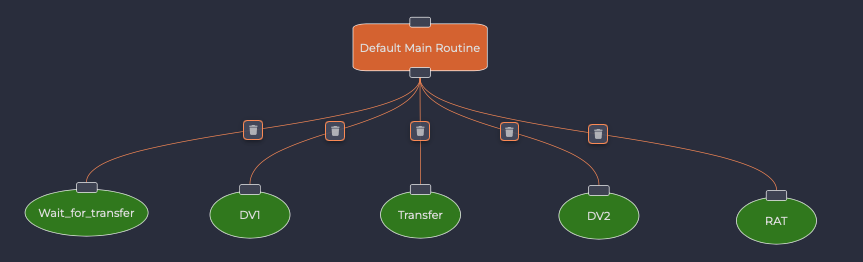

We will set the Delta V N values for DV1 and DV2 so lets find the blocks we need to adjust:

In [16]:
dv1_block = chaser_agent_branch.StaticThrustControlAlgorithm.get_where(name='Maneuver Thrust DV1')[0]
thruster = next(iter(dv1_block.thrusters.keys()))
dv1_block.update( thrusters= {thruster.id: {'thrust': dv1_N} })
dv1_block


StaticThrustControlAlgorithm(
   disabled=False
   id='PLxh3dpWNTlNXQB2H69DsH'
   name='Maneuver Thrust DV1'
   rate=None
   thrustCommands=None
   thrusterGroups={}
   thrusters={'PLxh55BnBYqvRxlSzQ8RP9': {'thrust': 2129.3022583474176}}
   timeStepDriver=None
   type='StaticThrustControlAlgorithm'
)

In [17]:

dv2_block = chaser_agent_branch.StaticThrustControlAlgorithm.get_where(name='Maneuver Thrust DV2')[0]
thruster = next(iter(dv2_block.thrusters.keys()))
dv2_block.update( thrusters= {thruster.id: {'thrust': dv2_N} })
dv2_block



StaticThrustControlAlgorithm(
   disabled=False
   id='PLxhH3m4GGcj6ThkMMfnB6'
   name='Maneuver Thrust DV2'
   rate=None
   thrustCommands=None
   thrusterGroups={}
   thrusters={'PLxh55BnBYqvRxlSzQ8RP9': {'thrust': 1896.4440411144708}}
   timeStepDriver=None
   type='StaticThrustControlAlgorithm'
)

Next we update the burn schedules for each phase

In [18]:
wait_for_dv1_routine = chaser_agent_branch.Routine.get_where(name = 'Wait_for_transfer')[0]
dv1_routine          = chaser_agent_branch.Routine.get_where(name = 'DV1')[0]
transfer_routine     = chaser_agent_branch.Routine.get_where(name = 'Transfer')[0]
dv2_routine          = chaser_agent_branch.Routine.get_where(name = 'DV2')[0]
rat_routine          = chaser_agent_branch.Routine.get_where(name = 'RAT')[0]


In [19]:
routine_map = {
    wait_for_dv1_routine.id: wait_for_dv1_routine.name,
    dv1_routine.id: dv1_routine.name,
    transfer_routine.id: transfer_routine.name,
    dv2_routine.id: dv2_routine.name,
    rat_routine.id: rat_routine.name
}

In [20]:
routine_map

{'PLxkBYb5cdCpR2Cjhx6Mpm': 'Wait_for_transfer',
 'PLxC4Nqcg55vqBRhwSVpv9': 'DV1',
 'PLxhrYrJJWTPFNBnmbBCCt': 'Transfer',
 'PLxC4NqfgNBRJv7hGPSFxW': 'DV2',
 'PLxC4NqhfyGTjLH59tLtrN': 'RAT'}

In [21]:
relative_schedule = chaser_agent_branch.RelativeSchedule.get_where(name = 'Default Main Routine')[0]
# update the existing schedule, which are in minutes
for routine, data in relative_schedule.scheduleData.items():
    match  routine_map[routine.id]:
        case 'Wait_for_transfer':
            data['activeTimes'][0][0]['min'] = 0
            data['activeTimes'][0][1]['min'] = (wait_seconds_to_dv1 - dv_1_burn_length_secs )/60.0 
        case 'DV1':
            data['activeTimes'][0][0]['min'] = (wait_seconds_to_dv1 - dv_1_burn_length_secs )/60.0 
            data['activeTimes'][0][1]['min'] = (wait_seconds_to_dv1 )/60.0 
        case 'Transfer':
            data['activeTimes'][0][0]['min'] = (wait_seconds_to_dv1 )/60.0 
            data['activeTimes'][0][1]['min'] = (wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs - dv_2_burn_length_secs )/60.0
        case 'DV2':
            data['activeTimes'][0][0]['min'] = (wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs - dv_2_burn_length_secs )/60.0
            data['activeTimes'][0][1]['min'] = (wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs )/60.0
        case 'RAT':
            data['activeTimes'][0][0]['min'] = (wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs )/60.0
            data['activeTimes'][0][1]['min'] = 1440.0 # minutes in a day
        case _:
            print(f'Unknown routine id {routine.id}')

relative_schedule.update(scheduleData=relative_schedule.data['scheduleData'])


RelativeSchedule(
   activeSubroutine=None
   defaultSubroutine='PLxkBYb5cdCpR2Cjhx6Mpm'
   disabled=False
   id='PLxBzFxMZ3FKVvCBtTH6C5'
   isActive=False
   mainRoutine='PLxBzFxMZ3FKVvCBtTH6C5'
   name='Default Main Routine'
   parentRoutines=[]
   pathToActiveLeaf=[]
   scheduleData={'PLxC4Nqcg55vqBRhwSVpv9': {'activeTimes': [[{'min': 208.09056634716055}, {'min': 209.09056634716055}]]}, 'PLxC4NqfgNBRJv7hGPSFxW': {'activeTimes': [[{'min': 273.08230088972}, {'min': 274.08230088972}]]}, 'PLxC4NqhfyGTjLH59tLtrN': {'activeTimes': [[{'min': 274.08230088972}, {'min': 1440.0}]]}, 'PLxhrYrJJWTPFNBnmbBCCt': {'activeTimes': [[{'min': 209.09056634716055}, {'min': 273.08230088972}]]}, 'PLxkBYb5cdCpR2Cjhx6Mpm': {'activeTimes': [[{'min': 0.0}, {'min': 208.09056634716055}]]}}
   startElapsedTime={'s': -1.0}
   subroutines=['PLxkBYb5cdCpR2Cjhx6Mpm', 'PLxC4NqfgNBRJv7hGPSFxW', 'PLxhrYrJJWTPFNBnmbBCCt', 'PLxC4Nqcg55vqBRhwSVpv9', 'PLxC4NqhfyGTjLH59tLtrN']
   timeSinceActive={'day': 1000000.0}
   timeSi

Run the Sim

In [22]:
sim = scenario_branch.simulation
# Start scenario
sim.start()


In [23]:

# Wait for it to finish, then get results
results = sim.results_poll()


Downloading...: 100%|██████████[00:03<00:00]


In [24]:

# Summarize results
results.summarize()

---------------------------------------------------------------------------
                      Sedaro Simulation Result Summary                     
---------------------------------------------------------------------------
✅ Simulation succeeded after 168.1s

🛰️ Templated Agents 
    • Chaser
    • Target
---------------------------------------------------------------------------
❓ Query agent results with .agent(<NAME>)


Load results and analyse

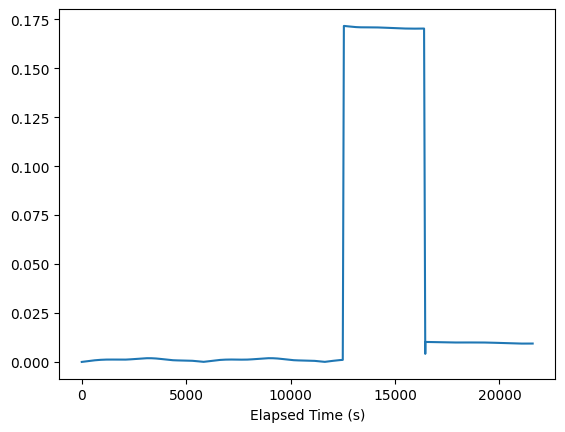

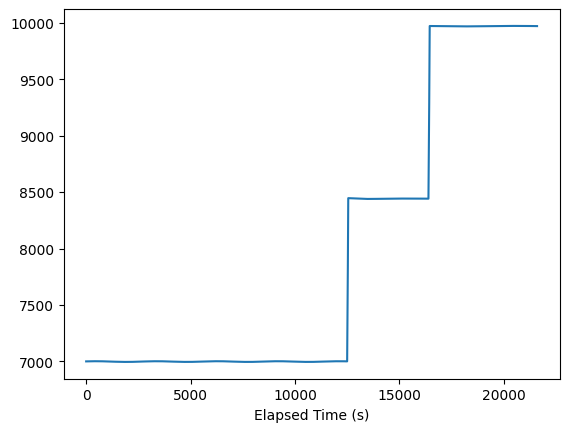

In [25]:
results.agent('Chaser').block('YddJw9jfT-IveoP86XQjA').orbitalElements.e.plot()
results.agent('Chaser').block('YddJw9jfT-IveoP86XQjA').orbitalElements.a.plot()


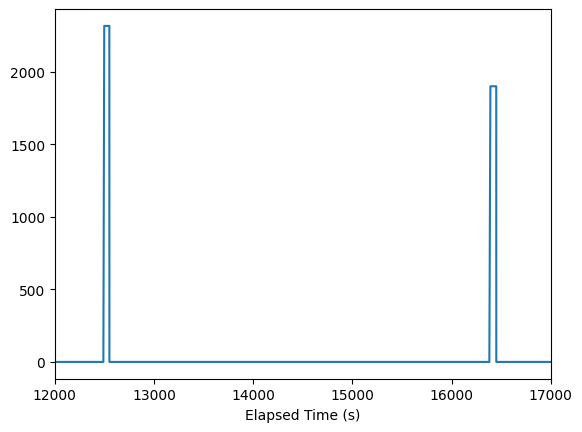

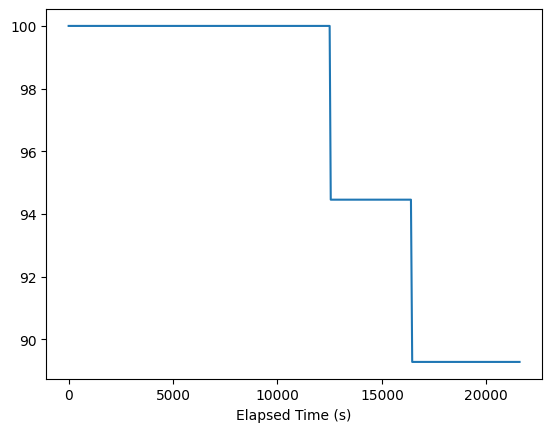

In [26]:
results.agent('Chaser').block('PLxh55BnBYqvRxlSzQ8RP9').thrust.plot(xlim=[12000,17000])
results.agent('Chaser').block('PLxhCcSfP9VJ9hd3p3vmPc').wetMass.plot()

Maneuver plot

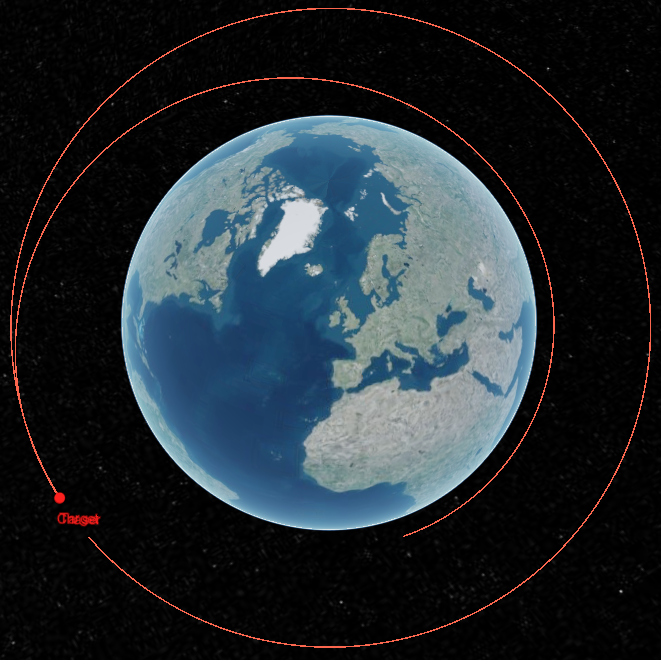

End of Transfer - Delta due to simplification of Delta Mass during the Burn phases and other ideal condition assumptions 

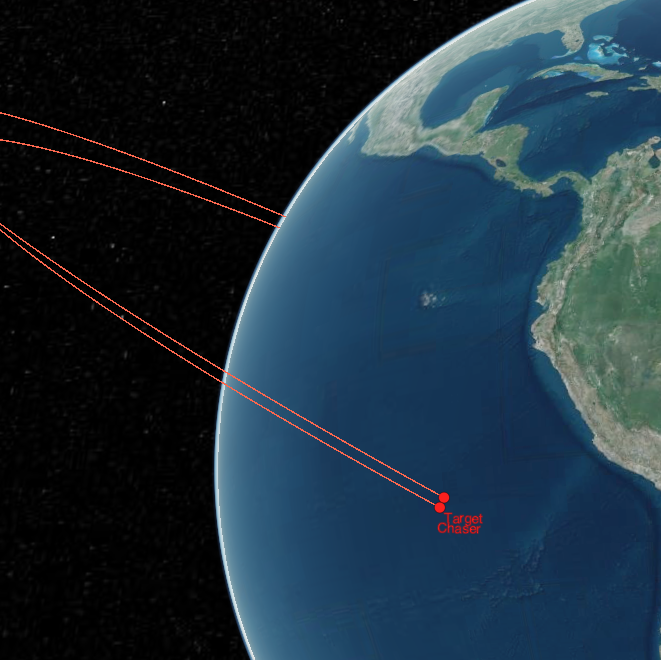

Calculate how close we got

In [27]:
import numpy as np
secs2days = 1/(24*60*60)

def calc_distance_between_agents(agent1, agent2, simtime_mjd):
    position1_ecf = agent1.block('root').position['ecef'].value_at(simtime_mjd)
    position2_ecf = agent2.block('root').position['ecef'].value_at(simtime_mjd)
    vector_between_them   = np.asarray(position2_ecf) - np.asarray(position1_ecf)
    distance_between_them = np.linalg.norm(vector_between_them)
    return distance_between_them

rendezvous_simtime_secs = wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs 
sim_start_mjd           = scenario_branch.ClockConfig.get_first().startTime
rendezvous_simtime_mjd  = rendezvous_simtime_secs*secs2days + sim_start_mjd

calc_distance_between_agents(results.agent('Chaser'), results.agent('Target'), rendezvous_simtime_mjd)

362.23254044765366

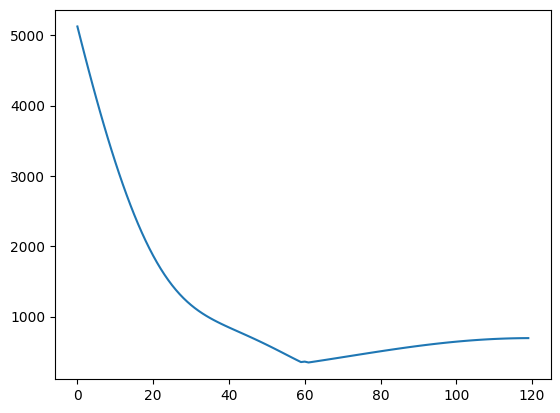

In [28]:
distance_between_them_over_longer_time = [calc_distance_between_agents(results.agent('Chaser'), results.agent('Target'), simtimesecs*secs2days + sim_start_mjd) 
                                   for simtimesecs in range(int(rendezvous_simtime_secs-60*60), int(rendezvous_simtime_secs) + 60*60, 60) ]

plt.plot(distance_between_them_over_longer_time)

In [29]:
print(min(distance_between_them_over_longer_time))

346.5597043315823
